
# i2DBSCAN for DEBUGING

### This code works for root files



In [1]:
def pedsub(img,pedarr):
    return img - pedarr
    
def zsfullres(img_sub,noisearr,nsigma=1):
    img_zs = np.where(img_sub > nsigma * noisearr, img_sub, 0)
    return img_zs

def noisearray(th2):
    noisearr = np.zeros( (th2.GetNbinsX(),th2.GetNbinsY()) )
    for ix in range(th2.GetNbinsX()):
        for iy in range(th2.GetNbinsY()):
            noisearr[ix][iy] = th2.GetBinError(ix+1,iy+1)
    return noisearr

Filename: ../histogram_Run00723.root
Picname: run723_00016
[Image Loaded]
[Pedestal Loaded]
[Edges Calculated]
[3D Method]
[i2DBSCAN Calculated]
[Statistics]
Total number of Clusters: 14
Clusters found in iteration 1: 0
Clusters found in iteration 2: 11
Clusters found in iteration 3: 3
[Plotting ALL iteration]


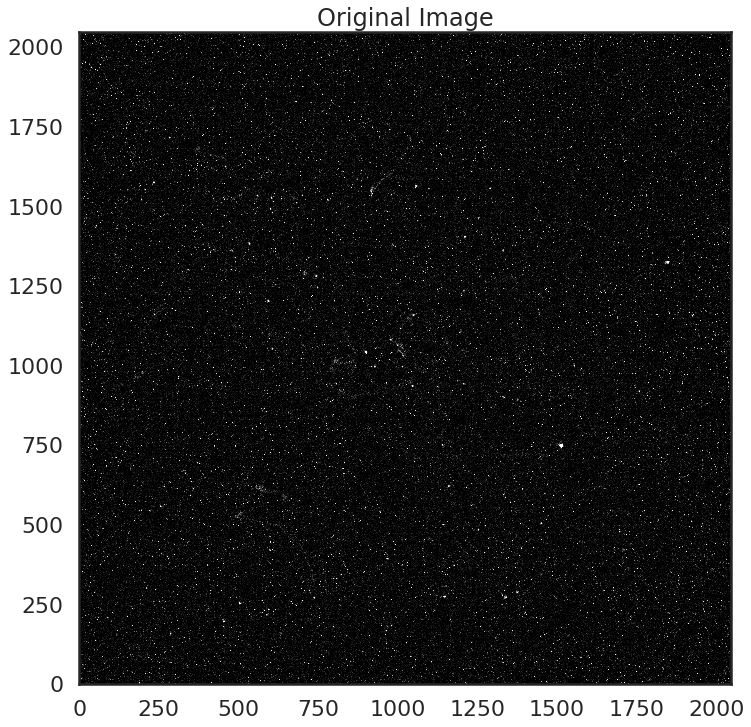

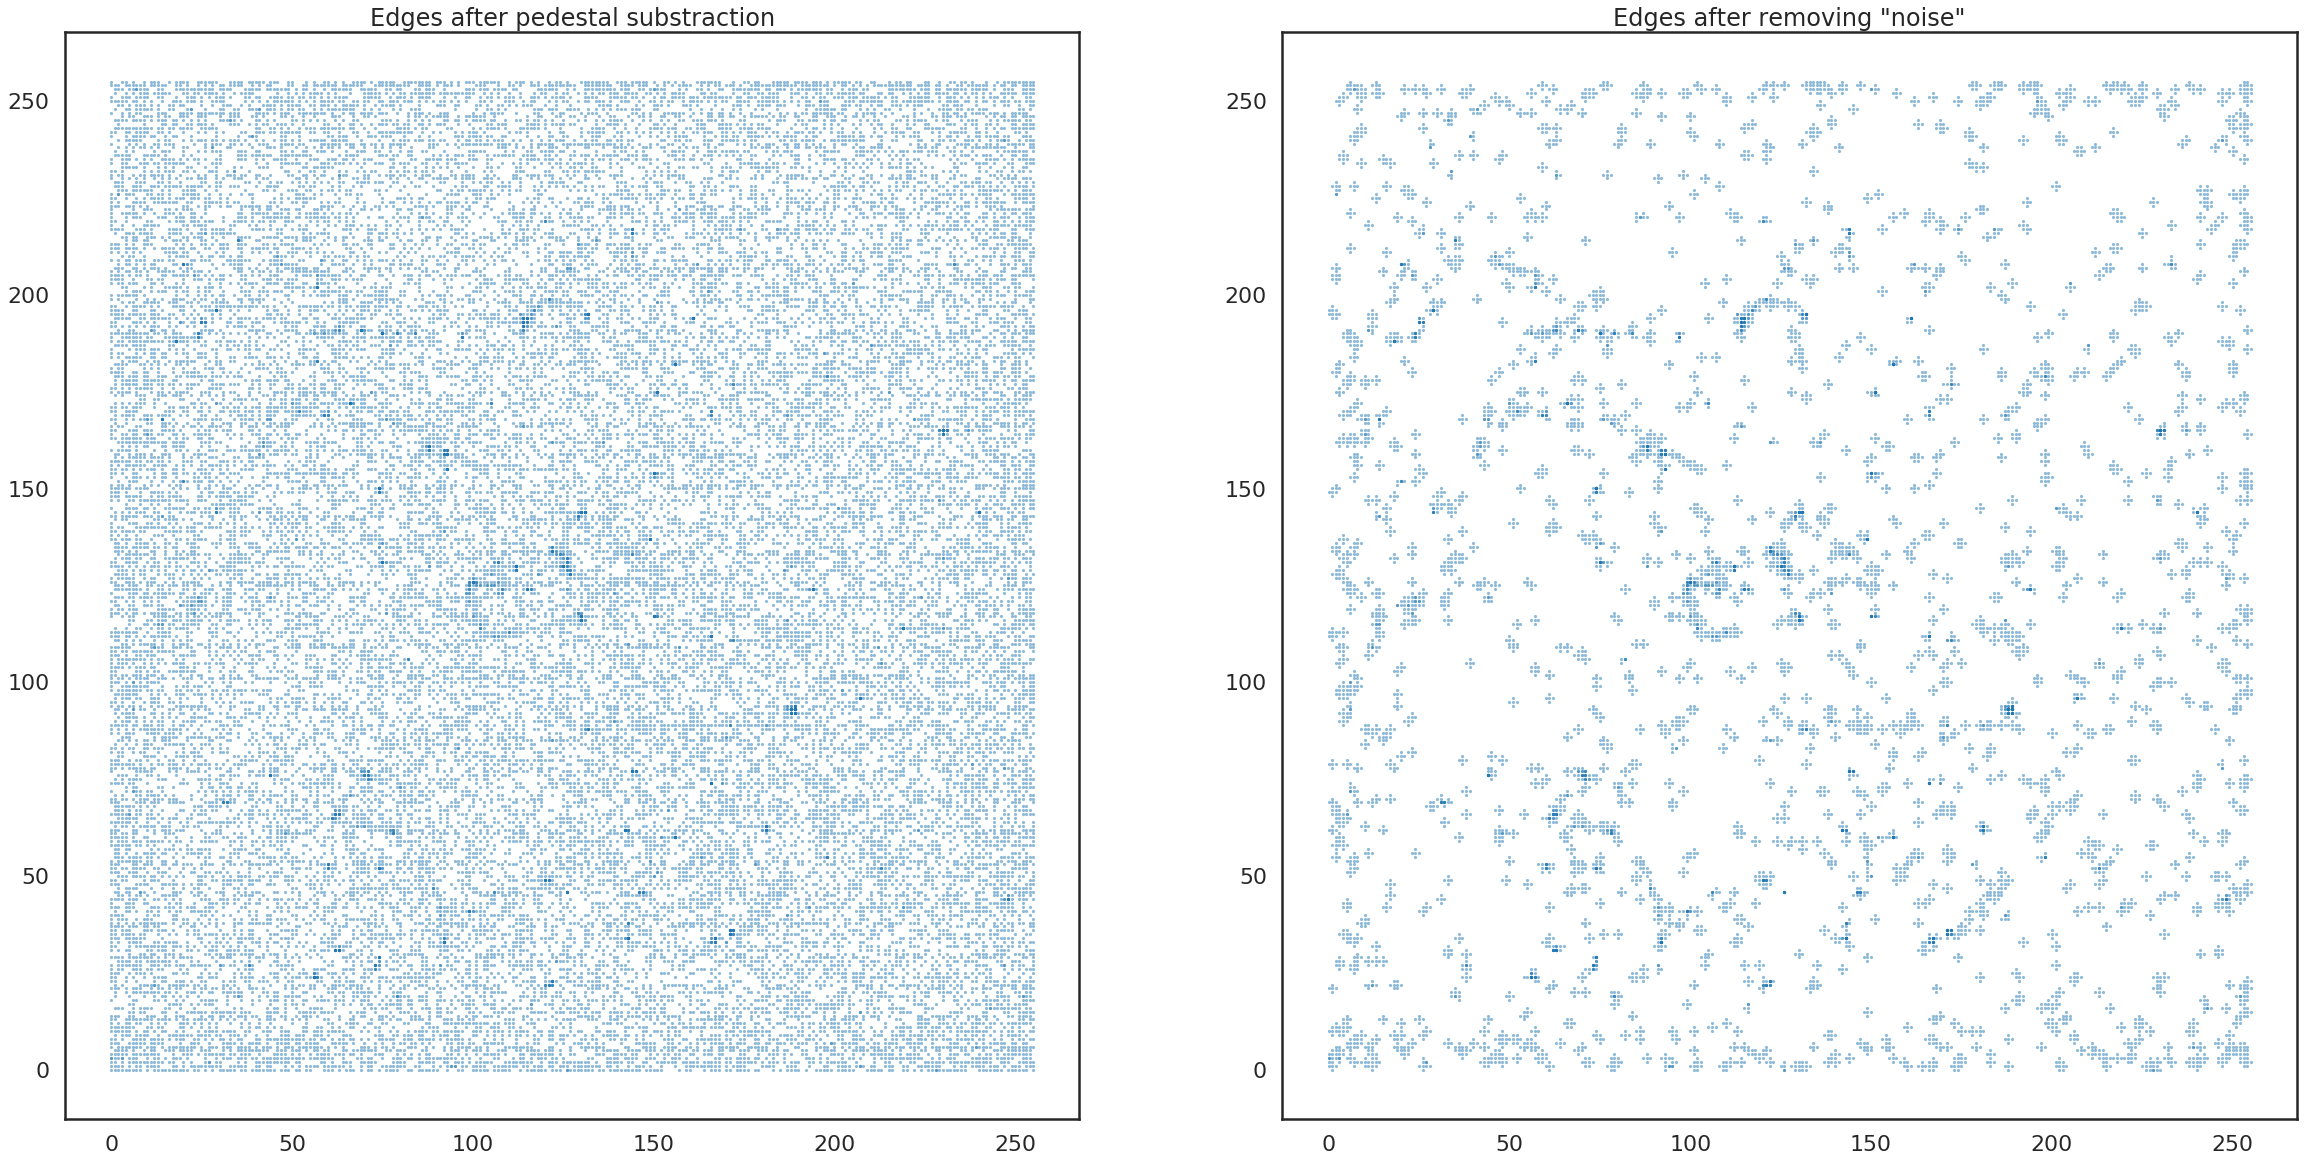

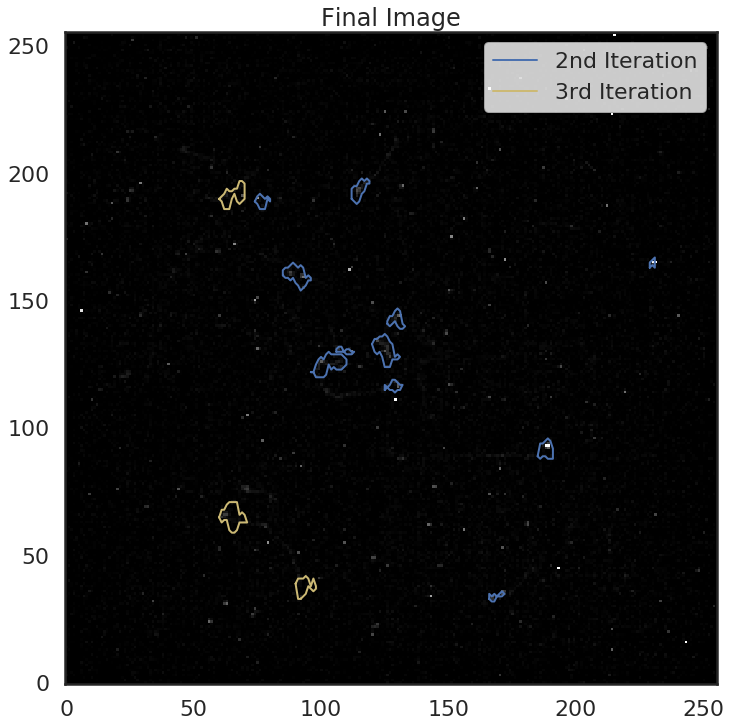

In [20]:
## IMPORTING LIBRARIES

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import ROOT

import tools_lib as tl
import sys
sys.path.insert(1, '../')

from iDBSCAN import iDBSCAN
from root_numpy import hist2array
from matplotlib.pyplot import *
from scipy.spatial import distance
from sklearn.cluster import DBSCAN
from sklearn import metrics
from IPython.display import set_matplotlib_formats

%matplotlib inline
## Setting plotting parameters
set_matplotlib_formats('png', 'pdf')
sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.5, 's' : 30, 'linewidths':0}
cmapcolor = 'gray' # or 'viridis'
vmin      = 99
vmax      = 125
figsizeX  = 12 
figsizeY  = 12

## Setting Debug Flags

flag_full_image     = 1
flag_rebin_image    = 0
flag_edges_image    = 0
flag_first_it       = 0
flag_second_it      = 0
flag_third_it       = 0
flag_stats          = 1
flag_all_it         = 1
flag_plot_noise     = 1

## Setting environments variables

rescale     = 512
cimax       = 200
nsigma      = 2        # numero di sigma sopra il piedistallo

## Setting i2DBSCAN parameters

iterative     = 4
tip           = '3D'               # 3D

scale = 4

if tip == '3D':
    vector_eps         =  [ 1,   2,  3.2,  5] #[ 3,    5,  7,  9]   #[2.26, 3, 3.5, 4]     #[2, 3, 3.5, 4]      #FOR FNG    #[2.26, 3.5, 2.8, 6]
    vector_min_samples =  [5, 100, 40, 50]#[30,  200,  100, 100] #[30,  150,  80, 40]   #[30,  55,  28, 13]    #[3,  55,  28, 13]            # [2, 30, 6, 2]
    #vector_eps         = list(np.array(vector_eps, dtype=float)/scale)
    #vector_min_samples = list(np.array(vector_min_samples, dtype=float)/scale)
else:
    vector_eps         = [2, 2.9, 3.2, 4]
    vector_min_samples = [3,  18,  17, 7]

cuts = [4500, 100]                # the cut on the length of the track for iteration 1 and 2
cuts = list(np.array(cuts, dtype=float)/scale)

## File folder
evt               = '00016'#'00016'         # Use always FIVE caracters
numrun            = '00723'#'00724'         # Use always FIVE caracters
formattype        = 'h5'            # If the root files comes from h5 conversion use = 'h5'
filedir           = '../'   # Folder where the root file is placed
peddir            = '../pedestals/'   # Folder where the pedestal file is placed
expo              = '1000'             # Exposure time of the pedestal in ms

## Loading image for analysis
# otherwise use 'mid'
if formattype == 'mid':
    imagename     = 'histograms_Run'
    picname       = 'pic_run%s_ev%d' % (numrun,int(evt))
else:
    imagename     = 'histogram_Run'
    picname       = 'run%d_%s' % (int(numrun),evt)
    
filename = '%s%s%s.root' % (filedir,imagename,numrun)

print('Filename: %s' % (filename))
print('Picname: %s' % (picname))
    
tf2 = ROOT.TFile.Open(filename)
imageth2 = tf2.Get(picname)
image = hist2array(imageth2)
tf2.Close()

if flag_full_image == 1:
    fig = plt.figure(figsize=(figsizeX, figsizeY))
    plt.imshow(image,cmap=cmapcolor, vmin=vmin,vmax=vmax,origin='lower' )
    plt.title("Original Image")

print('[Image Loaded]')

# Loading Pedestal files

tf2ped  = ROOT.TFile.Open('%s/pedmap_ex%s_rebin1.root' % (peddir,expo))  # PEDESTAL MAP
pedmap  = tf2ped.Get('pedmap').Clone()                               # Getting the pedmap
pedmap.SetDirectory(None)
m_image = hist2array(pedmap)

s_image = noisearray(pedmap)

tf2ped.Close()

# pedrescale     = 2048
# m_image = np.zeros((pedrescale,pedrescale),dtype=float)
# s_image = np.zeros((pedrescale,pedrescale),dtype=float)
# for x in range(1,pedrescale+1):
#     for y in range(1,pedrescale+1):
#         m_image[x-1,y-1] = pedmap.GetBinContent(x,y)
#         s_image[x-1,y-1] = pedmap.GetBinError(x,y)

#rebin_th_image   = np.round(m_image + nsigma*s_image)       # Threshold Image
img_cimax = np.where(image < cimax, image, 0)
img_fr_sub = pedsub(img_cimax,m_image)
img_fr_zs  = zsfullres(img_fr_sub,s_image,nsigma=nsigma)


print('[Pedestal Loaded]')

# Subtracting Pedestal from Image
rebin_image     = tl.rebin(image, (rescale, rescale))         # Rebining the full resolution image
#edges           = (rebin_image > rebin_th_image) & (rebin_image < cimax) 
#points          = np.array(np.nonzero(edges)).T.astype(int)

edges  = tl.rebin(img_fr_zs,(rescale, rescale))
points = np.array(np.nonzero(np.round(edges))).astype(int).T
lp = points.shape[0]


if flag_rebin_image == 1:
    fig = plt.figure(figsize=(figsizeX, figsizeY))
    plt.imshow(rebin_image, cmap=cmapcolor, vmin=vmin, vmax=vmax, origin='lower' )
    plt.title("Rebinned Image")
    
if flag_edges_image == 1:
    fig = plt.figure(figsize=(figsizeX, figsizeY))
    plt.imshow(edges, cmap=cmapcolor, vmin=0, vmax=1, origin='lower' )
    plt.title("Edges Image")

print('[Edges Calculated]')

## Adding or not the third dimension

X = points.copy()

# if tip == '3D':
#     lp = len(points)
#     Xl = list(X.copy())
#     for cor in X:
#         for count in range(0,np.int(np.round(rebin_image[cor[0],cor[1]] - rebin_th_image[cor[0],cor[1]]) - 1)):
#             Xl.append(cor)
#     X = np.array(Xl)
#     np.save('corImg.npz',X)
#     print('[3D Method]')
# else:
#     print('[2D Method]')

if tip=='3D':
    Xl = [(ix,iy) for ix,iy in points]          # Aux variable to simulate the Z-dimension
    X1 = np.array(Xl).copy()                    # variable to keep the 2D coordinates
    for ix,iy in points:                        # Looping over the non-empty coordinates
        nreplicas = int(edges[ix,iy])-1
        for count in range(nreplicas):                                # Looping over the number of 'photons' in that coordinate
            Xl.append((ix,iy))                              # add a coordinate repeatedly 
    X = np.array(Xl)                                        # Convert the list to an array
    print('[3D Method]')
else:
    #     print('[2D Method]')
    X = points.copy()
    #X1 = X
    
## STARTING THE CLUSTERING

### Defining some environment variables for i2DBSCAN
#------------------------------------------------------------------
clusters = iDBSCAN(iterative = iterative, vector_eps = vector_eps, vector_min_samples = vector_min_samples, cuts = cuts, flag_plot_noise = flag_plot_noise ).fit(X)
#------------------------------------------------------------------ 

if tip == '3D':
    teste = clusters.tag_
    clusters.labels_ = clusters.labels_[range(0,lp)]
    clusters.tag_ = clusters.tag_[range(0,lp)]
    X = points.copy()
print('[i2DBSCAN Calculated]')

if flag_stats == 1:
    print('[Statistics]')
    n_clusters_ = len(set(clusters.labels_)) - (1 if -1 in clusters.labels_ else 0)
    print("Total number of Clusters: %d" % (n_clusters_))
    u,indices = np.unique(clusters.labels_,return_index = True)
    print("Clusters found in iteration 1: %d" % (sum(clusters.tag_[indices] == 1)))
    print("Clusters found in iteration 2: %d" % (sum(clusters.tag_[indices] == 2)))
    print("Clusters found in iteration 3: %d" % (sum(clusters.tag_[indices] == 3)))
    
if flag_first_it == 1:
    print('[Plotting 1st iteration]')
    u,indices = np.unique(clusters.labels_,return_index = True)
    clu = [X[clusters.labels_ == i] for i in u[list(np.where(clusters.tag_[indices] == 1)[0])].tolist()]
    
    fig = plt.figure(figsize=(figsizeX, figsizeY))
    plt.imshow(rebin_image,cmap=cmapcolor, vmin=vmin,vmax=vmax,origin='lower' )
    plt.title("Clusters found in iteration 1")

    for j in range(0,np.shape(clu)[0]):

        ybox = clu[j][:,0]
        xbox = clu[j][:,1]

        xri,yri = tl.getContours(xbox,ybox)
        plt.plot(xri,yri, '-r',linewidth=2)
        
if flag_second_it == 1:
    print('[Plotting 2nd iteration]')
    u,indices = np.unique(clusters.labels_,return_index = True)
    clu = [X[clusters.labels_ == i] for i in u[list(np.where(clusters.tag_[indices] == 2)[0])].tolist()]
    
    fig = plt.figure(figsize=(figsizeX, figsizeY))
    plt.imshow(rebin_image,cmap=cmapcolor, vmin=vmin,vmax=vmax,origin='lower' )
    plt.title("Clusters found in iteration 2")

    for j in range(0,np.shape(clu)[0]):

        ybox = clu[j][:,0]
        xbox = clu[j][:,1]

        xri,yri = tl.getContours(xbox,ybox)
        plt.plot(xri,yri, '-b',linewidth=2)
        
if flag_third_it == 1:
    print('[Plotting 3rd iteration]')
    u,indices = np.unique(clusters.labels_,return_index = True)
    clu = [X[clusters.labels_ == i] for i in u[list(np.where(clusters.tag_[indices] == 3)[0])].tolist()]
    
    fig = plt.figure(figsize=(figsizeX, figsizeY))
    plt.imshow(rebin_image,cmap=cmapcolor, vmin=vmin,vmax=vmax,origin='lower' )
    plt.title("Clusters found in iteration 3")

    for j in range(0,np.shape(clu)[0]):

        ybox = clu[j][:,0]
        xbox = clu[j][:,1]
        
        if (len(ybox) > 0) and (len(xbox) > 0):
            xri,yri = tl.getContours(xbox,ybox)
            plt.plot(xri,yri, '-y',linewidth=2)

if flag_all_it == 1:
    print('[Plotting ALL iteration]')
    u,indices = np.unique(clusters.labels_,return_index = True)
    clu = [X[clusters.labels_ == i] for i in u[list(np.where(clusters.tag_[indices] == 1)[0])].tolist()]
    
    fig = plt.figure(figsize=(figsizeX, figsizeY))
    plt.imshow(rebin_image,cmap=cmapcolor, vmin=vmin,vmax=vmax,origin='lower' )
    plt.title("Final Image")

    for j in range(0,np.shape(clu)[0]):

        ybox = clu[j][:,0]
        xbox = clu[j][:,1]
        
        if (len(ybox) > 0) and (len(xbox) > 0):
            xri,yri = tl.getContours(xbox,ybox)
            line, = plt.plot(xri,yri, '-r',linewidth=2)
            if j == 0:
                line.set_label('1st Iteration')
        
    clu = [X[clusters.labels_ == i] for i in u[list(np.where(clusters.tag_[indices] == 2)[0])].tolist()]

    for j in range(0,np.shape(clu)[0]):

        ybox = clu[j][:,0]
        xbox = clu[j][:,1]
        
        if (len(ybox) > 0) and (len(xbox) > 0):
            xri,yri = tl.getContours(xbox,ybox)
            line, = plt.plot(xri,yri, '-b',linewidth=2)
            if j == 0:
                line.set_label('2nd Iteration')
        
    clu = [X[clusters.labels_ == i] for i in u[list(np.where(clusters.tag_[indices] == 3)[0])].tolist()]

    for j in range(0,np.shape(clu)[0]):

        ybox = clu[j][:,0]
        xbox = clu[j][:,1]
        
        if (len(ybox) > 0) and (len(xbox) > 0):
            xri,yri = tl.getContours(xbox,ybox)
            line, = plt.plot(xri,yri, '-y',linewidth=2)
            if j == 0:
                line.set_label('3rd Iteration')
    plt.legend()
    #plt.axis([175, 190, 275, 295])
